<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Importar os módulos

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import Dataset_transf as dprep
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import metrics, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Obter os dataframes dos ficheiros

In [2]:
metrics_dict={}
tentativa = 0

In [3]:
failures_df, signals_df, logs_df = dprep.get_data()

In [61]:
failures_df[failures_df.Component == 'GENERATOR'].sort_values('Timestamp')

,Turbine_ID,Component,Timestamp
0,T11,GENERATOR,2016-03-03 19:00:00
5,T06,GENERATOR,2016-07-11 19:40:00
7,T06,GENERATOR,2016-07-24 17:00:00
10,T06,GENERATOR,2016-09-04 08:00:00
11,T06,GENERATOR,2016-10-02 17:00:00
15,T06,GENERATOR,2016-10-27 16:20:00
22,T07,GENERATOR,2017-08-21 14:40:00


In [5]:
failures_df.Component.value_counts()

GENERATOR            7
GENERATOR_BEARING    6
HYDRAULIC_GROUP      5
TRANSFORMER          3
GEARBOX              2
Name: Component, dtype: int64

In [6]:
df_list = [failures_df, signals_df, logs_df]

# Criação de datasets de components

In [7]:
df_generator, df_gen_bear, df_transformer, df_hydraulic, df_gearbox = dprep.component_df_creation(signals_df)

In [8]:
comp_df_list = [df_generator, df_hydraulic, df_gen_bear, df_transformer,  df_gearbox]

In [9]:
for i in range(len(comp_df_list)):
    print(comp_df_list[i].shape)

(434145, 45)
(434145, 34)
(434145, 45)
(434145, 36)
(434145, 33)


In [10]:
component_list = failures_df.Component.unique()
component_list

array(['GENERATOR', 'HYDRAULIC_GROUP', 'GENERATOR_BEARING', 'TRANSFORMER',
       'GEARBOX'], dtype=object)

# Cópia dos df para só carregar uma vez no ficheiro

In [11]:
comp_prep_df_list = comp_df_list.copy()

# Merge dos DF com o DF de failures

In [12]:
for i in range(len(component_list)):
    comp_prep_df_list[i] = dprep.sig_fail_merge_dfs(sig_df=comp_prep_df_list[i],
                                               fail_df=failures_df,
                                               component=component_list[i])

In [13]:
for i in comp_df_list:
    print(i.shape)

(434145, 45)
(434145, 34)
(434145, 45)
(434145, 36)
(434145, 33)


# Fillna by turbine

In [14]:
turbine_list = signals_df.Turbine_ID.unique()
turbine_list

array(['T11', 'T06', 'T01', 'T09', 'T07'], dtype=object)

In [15]:
for i in range(len(component_list)):
    comp_prep_df_list[i] = dprep.fill_na_by_turbine(comp_prep_df_list[i], turbine_list)

C:\Users\ricar\code\RicardoJPedro82\wmillfailprev\notebooks\Dataset_transf.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  index['date'] = index['Timestamp']
C:\Users\ricar\code\RicardoJPedro82\wmillfailprev\notebooks\Dataset_transf.py:178: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_ = pd.concat([df_, df_final])
C:\Users\ricar\code\RicardoJPedro82\wmillfailprev\notebooks\Dataset_transf.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [16]:
for i in comp_prep_df_list:
    print(i.shape)

(434147, 47)
(434145, 36)
(434145, 47)
(434145, 38)
(434145, 35)


# Criação de Variável alvo

In [17]:
for i in range(len(comp_prep_df_list)):
    print(comp_prep_df_list[i].isna().sum().value_counts())

0    47
dtype: int64
0    36
dtype: int64
0    47
dtype: int64
0    38
dtype: int64
0    35
dtype: int64


In [18]:
days_list = [40]

In [19]:
for day in days_list:
    for i in range(len(comp_prep_df_list)):
        comp_prep_df_list[i] = dprep.aplic_var_target(comp_prep_df_list[i], day)

In [20]:
for i in comp_prep_df_list:
    print(i.shape)

(434147, 48)
(434145, 37)
(434145, 48)
(434145, 39)
(434145, 36)


# Feature selection

In [21]:
for i in comp_prep_df_list:
    print(i.keys().shape)

(48,)
(37,)
(48,)
(39,)
(36,)


In [22]:
gen_features_drop = [
    'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_Phase1_Temp_Avg', 'Gen_Phase3_Temp_Avg',
    'Amb_WindSpeed_Est_Avg', 'Grd_RtrInvPhase1_Temp_Avg',
    'Grd_RtrInvPhase3_Temp_Avg', 'Rtr_RPM_Max', 'Rtr_RPM_Min',
    'Blds_PitchAngle_Max', 'Blds_PitchAngle_Min',
    'Prod_LatestAvg_ReactPwrGen1', 'Cont_Hub_Temp_Avg', 'Spin_Temp_Avg',
    'Rtr_RPM_Std', 'Rtr_RPM_Avg', 'Cont_VCP_Temp_Avg'
]

In [23]:
gen_bear_features_drop = [
    'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_Phase1_Temp_Avg', 'Gen_Phase3_Temp_Avg',
    'Amb_WindSpeed_Est_Avg', 'Grd_RtrInvPhase1_Temp_Avg',
    'Grd_RtrInvPhase3_Temp_Avg', 'Rtr_RPM_Max', 'Rtr_RPM_Min',
    'Blds_PitchAngle_Max', 'Blds_PitchAngle_Min',
    'Prod_LatestAvg_ReactPwrGen1', 'Cont_Hub_Temp_Avg', 'Spin_Temp_Avg',
    'Rtr_RPM_Std', 'Rtr_RPM_Avg', 'Cont_VCP_Temp_Avg'
]

In [24]:
hyd_features_drop = [
    'Rtr_RPM_Max', 'Rtr_RPM_Min', 'Blds_PitchAngle_Max', 'Blds_PitchAngle_Min',
    'Blds_PitchAngle_Max', 'Grd_RtrInvPhase3_Temp_Avg', 'Grd_Busbar_Temp_Avg',
    'Amb_WindSpeed_Est_Avg', 'Spin_Temp_Avg', 'Cont_Hub_Temp_Avg',
    'Grd_RtrInvPhase1_Temp_Avg', 'Cont_VCP_Temp_Avg'
]

In [25]:
gearbox_features_drop = [
    'Rtr_RPM_Max', 'Rtr_RPM_Min', 'Grd_RtrInvPhase1_Temp_Avg',
    'Grd_RtrInvPhase3_Temp_Avg', 'Blds_PitchAngle_Min', 'Blds_PitchAngle_Max',
    'Cont_VCP_Temp_Avg', 'Grd_Busbar_Temp_Avg', 'Amb_WindSpeed_Est_Avg',
    'Spin_Temp_Avg'
]

In [26]:
transf_features_drop = [
    'HVTrafo_Phase1_Temp_Avg', 'HVTrafo_Phase3_Temp_Avg', 'Rtr_RPM_Max',
    'Rtr_RPM_Min', 'Grd_RtrInvPhase1_Temp_Avg', 'Grd_RtrInvPhase3_Temp_Avg',
    'Blds_PitchAngle_Min', 'Blds_PitchAngle_Max', 'Amb_WindSpeed_Est_Avg',
    'Spin_Temp_Avg', 'Cont_VCP_Temp_Avg'
]

In [27]:
feat_drop_list = [
    gen_features_drop, hyd_features_drop, gen_bear_features_drop,
    transf_features_drop, gearbox_features_drop
]

In [28]:
for df in range(len(comp_prep_df_list)):
    print(f'A actualizar dataframe {df+1} de {len(comp_prep_df_list)}')
#     for col in feat_drop_list:
#         print(f'A apagar a coluna {col}')
    comp_prep_df_list[df] = comp_prep_df_list[df].drop(columns=feat_drop_list[df])

A actualizar dataframe 1 de 5
A actualizar dataframe 2 de 5
A actualizar dataframe 3 de 5
A actualizar dataframe 4 de 5
A actualizar dataframe 5 de 5


In [29]:
for i in comp_prep_df_list:
    print(i.shape)

(434147, 31)
(434145, 26)
(434145, 31)
(434145, 28)
(434145, 26)


In [30]:
for i in comp_prep_df_list:
    print(i.keys().shape)

(31,)
(26,)
(31,)
(28,)
(26,)


# Agrupar pela medida de tempo seleccionada.

In [31]:
for i in range(len(comp_prep_df_list)):
    print(comp_prep_df_list[i].shape)

(434147, 31)
(434145, 26)
(434145, 31)
(434145, 28)
(434145, 26)


In [32]:
# Passagem para dias
Agrup_por = 'Dia'
for i in range(len(comp_prep_df_list)):
    comp_prep_df_list[i] = dprep.group_por_frequency(comp_prep_df_list[i], period=Agrup_por)

In [33]:
# Passagem para dias 
for i in range(len(comp_prep_df_list)):
    print(comp_prep_df_list[i].shape)

(3042, 31)
(3041, 19)
(3041, 18)
(3041, 19)
(3041, 16)


# Adicionar as medidas de alisamento

In [34]:
for i in range(len(comp_prep_df_list)):
    print(comp_prep_df_list[i].shape)

(3042, 31)
(3041, 19)
(3041, 18)
(3041, 19)
(3041, 16)


In [35]:
for i in range(len(comp_prep_df_list)):
    comp_prep_df_list[i] = dprep.add_features(comp_prep_df_list[i], rolling_win_size=5)

In [36]:
cols_to_drop = [
    'Amb_Temp_Avg', 'Amb_WindDir_Abs_Avg', 'Amb_WindDir_Relative_Avg',
    'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min',
    'Amb_WindSpeed_Std', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std',
    'Cont_Top_Temp_Avg', 'Cont_VCP_ChokcoilTemp_Avg',
    'Cont_VCP_WtrTemp_Avg', 'Gen_Bear2_Temp_Avg', 'Gen_Bear_Temp_Avg',
    'Gen_Phase2_Temp_Avg', 'Gen_RPM_Avg', 'Gen_RPM_Std',
    'Gen_SlipRing_Temp_Avg', 'Grd_Busbar_Temp_Avg',
    'Grd_RtrInvPhase2_Temp_Avg', 'Hyd_Oil_Temp_Avg', 'Nac_Direction_Avg',
    'Nac_Temp_Avg', 'Prod_LatestAvg_ActPwrGen0', 'Prod_LatestAvg_ActPwrGen1',
    'Prod_LatestAvg_ReactPwrGen0'
]
comp_prep_df_list[0] = comp_prep_df_list[0].drop(columns=cols_to_drop)

In [37]:
cols_to_drop = [
    'Amb_WindDir_Abs_Avg', 'Amb_WindDir_Relative_Avg',
    'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min',
    'Amb_WindSpeed_Std', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std',
    'Nac_Direction_Avg', 'Rtr_RPM_Avg', 'Rtr_RPM_Std'
]
comp_prep_df_list[1] = comp_prep_df_list[1].drop(columns=cols_to_drop)

In [38]:
cols_to_drop =  ['Amb_WindDir_Abs_Avg', 'Amb_WindDir_Relative_Avg',
       'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min',
       'Amb_WindSpeed_Std', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std',
       'Gen_Bear_Temp_Avg', 'Gen_RPM_Avg', 'Gen_RPM_Std',
       'Nac_Direction_Avg', 'Prod_LatestAvg_ActPwrGen1']
comp_prep_df_list[2] = comp_prep_df_list[2].drop(columns=cols_to_drop)

In [39]:
cols_to_drop = ['Amb_WindDir_Abs_Avg', 'Amb_WindDir_Relative_Avg',
       'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min',
       'Amb_WindSpeed_Std', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std',
       'Grd_Prod_VoltPhse1_Avg', 'Grd_Prod_VoltPhse2_Avg',
       'Grd_Prod_VoltPhse3_Avg', 'Nac_Direction_Avg', 'Rtr_RPM_Avg',
       'Rtr_RPM_Std']
comp_prep_df_list[3] = comp_prep_df_list[3].drop(columns=cols_to_drop)

In [40]:
cols_to_drop = ['Amb_WindDir_Abs_Avg', 'Amb_WindDir_Relative_Avg',
       'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min',
       'Amb_WindSpeed_Std', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std',
       'Nac_Direction_Avg', 'Rtr_RPM_Avg', 'Rtr_RPM_Std']
comp_prep_df_list[4] = comp_prep_df_list[4].drop(columns=cols_to_drop)

In [41]:
for i in range(len(comp_prep_df_list)):
    print(comp_prep_df_list[i].shape)

(3042, 59)
(3041, 38)
(3041, 33)
(3041, 35)
(3041, 29)


# Train and test split

In [42]:
# Separar os dataframes de treino e teste
df_train = [0, 0, 0, 0, 0]
df_test = [0, 0, 0, 0, 0]

per_test = '3meses'

for i in range(len(comp_prep_df_list)):
    df_train[i] = dprep.prepare_train_df(comp_prep_df_list[i].copy(), meses=3)
    df_test[i] = dprep.prepare_test_df(comp_prep_df_list[i].copy(), meses=3)

In [43]:
for i in range(len(df_train)):
    print(f'df_train {i} com a forma {df_train[i].shape}')
    print(f'df_test {i} com a forma {df_test[i].shape}')

df_train 0 com a forma (2577, 59)
df_test 0 com a forma (465, 59)
df_train 1 com a forma (2576, 38)
df_test 1 com a forma (465, 38)
df_train 2 com a forma (2576, 33)
df_test 2 com a forma (465, 33)
df_train 3 com a forma (2576, 35)
df_test 3 com a forma (465, 35)
df_train 4 com a forma (2576, 29)
df_test 4 com a forma (465, 29)


# Criar o x_train, x_test, y_train e o y_test 

In [44]:
x_train = [0, 0, 0, 0, 0]
x_test = [0, 0, 0, 0, 0]
y_train = [0, 0, 0, 0, 0]
y_test = [0, 0, 0, 0, 0]

dias_var_alvo = days_list[0]

for i in range(len(df_train)):
    x_train[i] = df_train[i].copy()
    x_test[i] = df_test[i].copy()
    y_train[i] = df_train[i].copy()
    y_test[i] = df_test[i].copy()

In [45]:
'Component_av' in x_train[0].columns

True

In [46]:
# retirar as colunas que não devem entrar no x
cols_to_drop_train = ['Date', 'TTF', str(days_list[0])+'_days', 'Component', 'Component_av', 'Component_sd']
for i in range(len(x_train)):
    x_train[i].drop(columns=cols_to_drop_train, inplace=True)
    x_test[i].drop(columns=cols_to_drop_train, inplace=True)

In [47]:
for i in range(len(x_train)):
    print(f'x_train {i} com a forma {x_train[i].shape}')
    print(f'x_test {i} com a forma {x_test[i].shape}')

x_train 0 com a forma (2577, 53)
x_test 0 com a forma (465, 53)
x_train 1 com a forma (2576, 32)
x_test 1 com a forma (465, 32)
x_train 2 com a forma (2576, 27)
x_test 2 com a forma (465, 27)
x_train 3 com a forma (2576, 29)
x_test 3 com a forma (465, 29)
x_train 4 com a forma (2576, 23)
x_test 4 com a forma (465, 23)


In [48]:
# considerar apenas as colunas que devem ser a variável alvo
col_to_mantain_test = [str(days_list[0])+'_days']
for i in range(len(x_test)):
    y_train[i] = y_train[i][col_to_mantain_test]
    y_test[i] = y_test[i][col_to_mantain_test]

In [49]:
for i in range(len(y_test)):
    print(f'y_train {i} com a forma {y_train[i].shape}')
    print(f'y_test {i} com a forma {y_test[i].shape}')

y_train 0 com a forma (2577, 1)
y_test 0 com a forma (465, 1)
y_train 1 com a forma (2576, 1)
y_test 1 com a forma (465, 1)
y_train 2 com a forma (2576, 1)
y_test 2 com a forma (465, 1)
y_train 3 com a forma (2576, 1)
y_test 3 com a forma (465, 1)
y_train 4 com a forma (2576, 1)
y_test 4 com a forma (465, 1)


# Primeira tentativa

In [50]:
# Normalizar os dados
X_train, X_test = dprep.scale(x_train[0], x_test[0])

#Sem normalizar os dados
# X_train = x_train[0].drop(columns=['Turbine_ID']).to_numpy()
# X_test = x_test[0].drop(columns=['Turbine_ID']).to_numpy()

In [51]:
y_train = y_train[0].to_numpy().astype(int)[:,0]
y_test = y_test[0].to_numpy().astype(int)[:,0]

In [52]:
#def bin_classify(model, clf, features,target, df_train, df_test ,params=None, score=None, ):
model = 'Logistic Regression'
clf_LogReg = LogisticRegression(random_state=42, max_iter=1000)
gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'

clf_LogReg, pred_LogReg = dprep.bin_classify(model,
                                             clf_LogReg,
                                             X_train,
                                             X_test,
                                             y_train,
                                             y_test,
                                             params=gs_params,
                                             score=gs_score)
print('\nBest Parameters:\n', clf_LogReg)


Best Parameters:
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)


c:\users\ricar\.venvs\lewagon\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


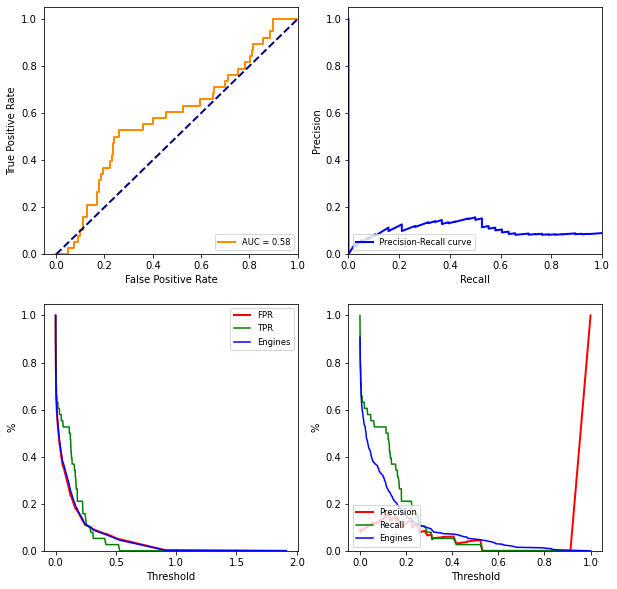

In [53]:
metrics_LogReg, roc_LogReg, prc_LogReg, cf_matriX_log_reg = dprep.bin_class_metrics(
    model,
    y_test,
    pred_LogReg.y_pred,
    pred_LogReg.y_score,
    print_out=True,
    plot_out=True)

In [54]:
tentativa = tentativa + 1

In [55]:
metrics_dict['try_'+str(tentativa)] =  {
        'Component': component_list[1],
        'dias_var_alvo': col_to_mantain_test,
        'feature_selection': 'Guilherme',
        'Agrup_por': Agrup_por,
        'add_features': 'smooth only',
        'per_test': per_test,
        'metrics_LogReg': metrics_LogReg,
        'cf_matriX_log_reg': cf_matriX_log_reg
    }

In [56]:
metrics_dict['try_'+str(tentativa)]#, metrics_dict['try002']['cf_matriX_log_reg']

{'Component': 'HYDRAULIC_GROUP',
 'dias_var_alvo': ['40_days'],
 'feature_selection': 'Guilherme',
 'Agrup_por': 'Dia',
 'add_features': 'smooth only',
 'per_test': '3meses',
 'metrics_LogReg':            Logistic Regression
 Accuracy              0.875269
 Precision             0.045455
 Recall                0.026316
 F1 Score              0.033333
 ROC AUC               0.583015,
 'cf_matriX_log_reg': array([[406,  21],
        [ 37,   1]], dtype=int64)}

In [57]:
for i in metrics_dict.keys():
    print(metrics_dict[i]['Component'])
    print(metrics_dict[i]['dias_var_alvo'])
    print(metrics_dict[i]['Agrup_por'])
    print(metrics_dict[i]['metrics_LogReg'])
    print(metrics_dict[i]['cf_matriX_log_reg'])

HYDRAULIC_GROUP
['40_days']
Dia
           Logistic Regression
Accuracy              0.875269
Precision             0.045455
Recall                0.026316
F1 Score              0.033333
ROC AUC               0.583015
[[406  21]
 [ 37   1]]


In [58]:
import csv
import json

In [59]:
w = csv.writer(open("output4.csv", "w"))
for key, val in metrics_dict.items():
    w.writerow([key, val])

# Cria de DF para avaliação de métricas

In [195]:
sav , cf_numb, met_df = dprep.metrics_create_df(df_test[0], y_test, pred_LogReg.y_pred.values, 15)

In [196]:
sav

-18750.0

In [197]:
cf_numb

{'TP': 1, 'TN': 406, 'FP': 6, 'FN': 0}

In [198]:
met_df[met_df.FP==1][met_df[met_df.FP==1].new_FP==1]

,Date,Turbine_ID,TTF,y_test,y_pred,TP,TN,FP,FN,new_FP
43,2017-07-14,T01,0.0,0,1,0,0,1,0,1.0
293,2017-06-15,T09,0.0,0,1,0,0,1,0,1.0
322,2017-07-14,T09,0.0,0,1,0,0,1,0,1.0
360,2017-08-21,T09,0.0,0,1,0,0,1,0,1.0
399,2017-06-28,T11,0.0,0,1,0,0,1,0,1.0
426,2017-07-25,T11,0.0,0,1,0,0,1,0,1.0
